<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
import datetime as dt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [92]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [93]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [94]:
X = df[:50000]
y = X['is_duplicate']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizerTf = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizerTf.fit(X_train['question1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_question1_tfidf = vectorizerTf.transform(X_train['question1'].values)
X_test_question1_tfidf = vectorizerTf.transform(X_test['question1'].values)

print("question1 after vectorizations in Tfidf")
print(X_train_question1_tfidf.shape, y_train.shape)
print(X_test_question1_tfidf.shape, y_test.shape)
print("="*100)

vectorizerTf_pt = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizerTf_pt.fit(X_train['question2'].values) # fit has to happen only on train data
X_train_question2_tfidf = vectorizerTf_pt.transform(X_train['question2'].values)
X_test_question2_tfidf = vectorizerTf_pt.transform(X_test['question2'].values)

print("question2 after vectorizations in Tfidf")
print(X_train_question2_tfidf.shape, y_train.shape)
print(X_test_question2_tfidf.shape, y_test.shape)

question1 after vectorizations in Tfidf
(33500, 5000) (33500,)
(16500, 5000) (16500,)
question2 after vectorizations in Tfidf
(33500, 5000) (33500,)
(16500, 5000) (16500,)


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [97]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import en_core_web_sm
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)

vecs3 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs3.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs3)


100%|██████████| 16500/16500 [02:59<00:00, 91.91it/s] 


In [98]:
vecs4 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs4.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs4)

vecs6 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs6.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs6)

100%|██████████| 16500/16500 [03:45<00:00, 73.09it/s]


In [99]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [100]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
#df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_tr = X_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_te = X_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [101]:
df3_tr_q1 = pd.DataFrame(df3_tr.q1_feats_m.values.tolist(), index= df3_tr.index)
df3_tr_q2 = pd.DataFrame(df3_tr.q2_feats_m.values.tolist(), index= df3_tr.index)

df3_te_q1 = pd.DataFrame(df3_te.q1_feats_m.values.tolist(), index= df3_te.index)
df3_te_q2 = pd.DataFrame(df3_te.q2_feats_m.values.tolist(), index= df3_te.index)


In [102]:
# dataframe of nlp features
df1.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [103]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [104]:
# Questions 1 tfidf weighted word2vec
df3_tr_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
24697,98.319917,3.115815,5.734983,-101.264887,-97.201126,55.460338,81.047686,88.190482,-24.562785,23.413108,...,-12.551901,-26.496574,41.631687,40.011074,2.399758,-46.505499,10.024556,-36.470840,-29.807411,16.793309
9189,94.982875,-194.631318,-85.506460,-251.303578,-218.882829,43.569252,269.215601,20.952992,-90.716261,116.568531,...,202.869745,-94.995093,25.967321,100.758782,7.331631,-11.528214,-107.742010,146.360826,-23.474489,183.292336
21416,144.679862,-90.829158,-36.517924,-95.178314,-60.494163,-5.004270,124.336419,88.731239,50.538857,162.863239,...,26.664502,6.890466,21.722139,45.412941,16.047979,2.893266,36.363346,16.093293,58.752688,-9.523747
35629,63.981206,-29.526385,-18.535272,-49.144417,-57.478454,-5.652093,1.752339,62.456176,-31.970114,50.081650,...,25.555840,-8.909108,29.033035,11.228556,17.956979,4.234054,34.129730,27.437058,12.560656,22.141303
17998,170.834070,-31.068764,-126.877227,-166.221617,-91.554419,96.504781,38.331185,28.874115,-22.831581,126.082637,...,62.629793,-120.408651,131.196783,57.818572,-35.168071,7.636867,106.536101,7.421218,-81.860299,59.367500


In [105]:
df3_tr_q1['id'] = df1['id']
df3_tr_q2['id'] = df1['id']

df3_te_q1['id'] = df1['id']
df3_te_q2['id'] = df1['id']

In [106]:
df3_tr_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
24697,98.319917,3.115815,5.734983,-101.264887,-97.201126,55.460338,81.047686,88.190482,-24.562785,23.413108,...,-26.496574,41.631687,40.011074,2.399758,-46.505499,10.024556,-36.470840,-29.807411,16.793309,24697
9189,94.982875,-194.631318,-85.506460,-251.303578,-218.882829,43.569252,269.215601,20.952992,-90.716261,116.568531,...,-94.995093,25.967321,100.758782,7.331631,-11.528214,-107.742010,146.360826,-23.474489,183.292336,9189
21416,144.679862,-90.829158,-36.517924,-95.178314,-60.494163,-5.004270,124.336419,88.731239,50.538857,162.863239,...,6.890466,21.722139,45.412941,16.047979,2.893266,36.363346,16.093293,58.752688,-9.523747,21416
35629,63.981206,-29.526385,-18.535272,-49.144417,-57.478454,-5.652093,1.752339,62.456176,-31.970114,50.081650,...,-8.909108,29.033035,11.228556,17.956979,4.234054,34.129730,27.437058,12.560656,22.141303,35629
17998,170.834070,-31.068764,-126.877227,-166.221617,-91.554419,96.504781,38.331185,28.874115,-22.831581,126.082637,...,-120.408651,131.196783,57.818572,-35.168071,7.636867,106.536101,7.421218,-81.860299,59.367500,17998


In [107]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_tr_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_tr_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_tr_q1.shape[1]+df3_tr_q2.shape[1])

Number of features in nlp dataframe : 16
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 97
Number of features in question2 w2v  dataframe : 97
Number of features in final dataframe  : 222


In [108]:
X_train.drop(['is_duplicate'], axis=1, inplace=True)
X_test.drop(['is_duplicate'], axis=1, inplace=True)

In [109]:
X_train['id']=df1['id']
X_test['id']=df1['id']

In [110]:
df1=df1.merge(df2, on='id',how='left')

In [111]:
df1_train=X_train.merge(df1, on='id',how='left')
df1_test=X_test.merge(df1, on='id',how='left')
df1_train.shape

(33500, 33)

In [112]:
df1_train.head()

,id,qid1,qid2,question1,question2,q1_feats_m,q2_feats_m,cwc_min,cwc_max,csc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,24697,46105,46106,What will replace HTML and CSS in the future?,What will replace HTML and CSS?,"[98.31991684436798, 3.1158151626586914, 5.7349...","[60.13689720630646, -0.7491765022277832, 19.51...",0.999967,0.749981,0.999967,...,1,45,31,9,6,5.0,15.0,0.333333,2,0
1,9189,17865,17866,How you interpet the conflict between the way ...,What are the signs of mid life crisis ending?,"[94.98287469148636, -194.63131844997406, -85.5...","[133.81881606578827, -75.25999683141708, -6.78...",0.000000,0.000000,0.499988,...,1,116,45,18,9,2.0,24.0,0.083333,2,0
2,21416,40324,40325,Is there a way to play League of Legends on Ch...,What are good ways to tilt your own team in Le...,"[144.67986154556274, -90.82915759086609, -36.5...","[203.56822526454926, -123.74452328681946, -43....",0.399992,0.333328,0.333328,...,1,55,62,11,13,3.0,24.0,0.125000,3,1
3,35629,65074,65075,How do I do business with Alibaba?,How do I have a business like alibaba?,"[63.98120641708374, -29.52638485096395, -18.53...","[39.01227426528931, -39.95911717414856, -35.32...",0.999950,0.666644,0.749981,...,1,34,38,7,8,5.0,14.0,0.357143,2,0
4,17998,34127,12950,What is your analysis of 2016-17 KVPY aptitude...,What do you think the cutoff of KVPY 2016 SA w...,"[170.83406955003738, -31.068763898685575, -126...","[177.84210778027773, -27.644847512245178, -74....",0.666656,0.444440,0.833319,...,18,92,54,17,12,8.0,28.0,0.285714,19,17


In [113]:
dvtr=df1_train.drop(['qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)
dvte=df1_test.drop(['qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)
dvtr.shape

(33500, 27)

In [114]:
dvtr.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,24697,0.999967,0.749981,0.999967,0.599988,0.999983,0.666659,0.0,1.0,3.0,...,1,45,31,9,6,5.0,15.0,0.333333,2,0
1,9189,0.000000,0.000000,0.499988,0.285710,0.222220,0.105263,0.0,0.0,10.0,...,1,116,45,18,9,2.0,24.0,0.083333,2,0
2,21416,0.399992,0.333328,0.333328,0.285710,0.363633,0.307690,0.0,0.0,2.0,...,1,55,62,11,13,3.0,24.0,0.125000,3,1
3,35629,0.999950,0.666644,0.749981,0.599988,0.714276,0.624992,1.0,1.0,1.0,...,1,34,38,7,8,5.0,14.0,0.357143,2,0
4,17998,0.666656,0.444440,0.833319,0.624992,0.749994,0.499997,1.0,1.0,6.0,...,18,92,54,17,12,8.0,28.0,0.285714,19,17


In [115]:
dfftr  = df3_tr_q1.merge(df3_tr_q2, on='id',how='left')
dffte  = df3_te_q1.merge(df3_te_q2, on='id',how='left')
dfftr.shape

(33500, 193)

In [116]:
dfftr.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,98.319917,3.115815,5.734983,-101.264887,-97.201126,55.460338,81.047686,88.190482,-24.562785,23.413108,...,1.362661,-0.772517,38.415904,13.415317,21.351429,-44.915582,47.475019,-42.786485,1.093703,18.111886
1,94.982875,-194.631318,-85.506460,-251.303578,-218.882829,43.569252,269.215601,20.952992,-90.716261,116.568531,...,63.339597,15.101871,99.384455,-26.260867,-93.640605,-35.812191,-82.408813,-1.991099,-105.205338,137.387194
2,144.679862,-90.829158,-36.517924,-95.178314,-60.494163,-5.004270,124.336419,88.731239,50.538857,162.863239,...,46.658452,48.112271,23.051253,10.956369,10.307188,-14.488136,38.028886,6.958647,6.892108,-37.763746
3,63.981206,-29.526385,-18.535272,-49.144417,-57.478454,-5.652093,1.752339,62.456176,-31.970114,50.081650,...,23.272400,-29.343294,96.503701,4.979759,-15.231231,20.544052,8.518478,-12.314482,-33.052059,13.449668
4,170.834070,-31.068764,-126.877227,-166.221617,-91.554419,96.504781,38.331185,28.874115,-22.831581,126.082637,...,66.154941,-34.199759,-6.474558,62.644513,3.232338,-56.288527,137.879845,52.494204,-38.955466,82.889999


In [117]:
X_tr_old  = dfftr.merge(dvtr, on='id',how='left')
X_te_old  = dffte.merge(dvte, on='id',how='left')
X_tr_old.shape

(33500, 219)

In [118]:
X_te_old.shape

(16500, 219)

In [119]:
dvtr.drop(['id'], axis=1, inplace=True)
dvte.drop(['id'], axis=1, inplace=True)

In [120]:
# Please write all the code with proper documentation
from scipy.sparse import hstack
X_tr = hstack((X_train_question1_tfidf,X_train_question2_tfidf, dvtr)).tocsr()
X_te = hstack((X_test_question1_tfidf,X_test_question2_tfidf,dvte)).tocsr()

#Various countVectorizers are stacked in same order as in X_train or others' original data

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 10026) (33500,)
(16500, 10026) (16500,)


<h1>4. Machine Learning Models </h1>

In [121]:
X_tr_old.drop(['id'], axis=1, inplace=True)
X_te_old.drop(['id'], axis=1, inplace=True)

In [122]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.1 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.42392488104205717
For values of alpha =  0.0001 The log loss is: 0.443565084327864
For values of alpha =  0.001 The log loss is: 0.4269262583106046
For values of alpha =  0.01 The log loss is: 0.4551320805436927
For values of alpha =  0.1 The log loss is: 0.4695747500025206
For values of alpha =  1 The log loss is: 0.4994315467274495
For values of alpha =  10 The log loss is: 0.5496166076103123


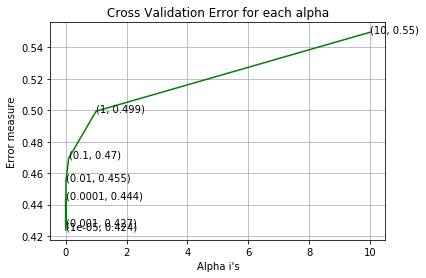

For values of best alpha =  1e-05 The train log loss is: 0.4108435972194073
For values of best alpha =  1e-05 The test log loss is: 0.42392488104205717
Total number of data points : 16500


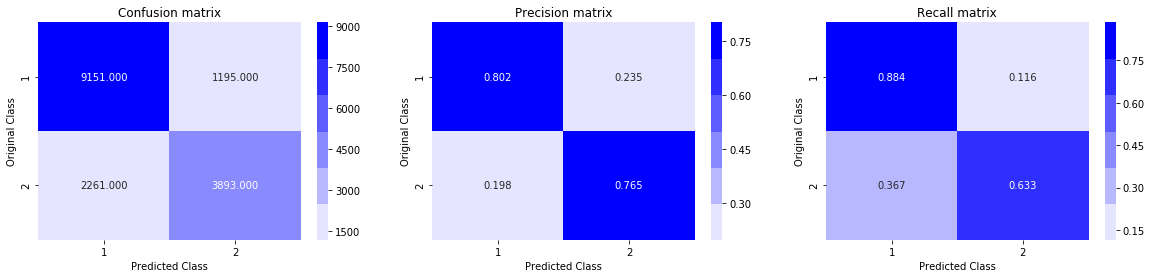

In [68]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    predict_y = sig_clf.predict_proba(X_te)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.2 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4371728985939949
For values of alpha =  0.0001 The log loss is: 0.4679306598785423


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.001 The log loss is: 0.4915810968233997


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.01 The log loss is: 0.5199321941856232
For values of alpha =  0.1 The log loss is: 0.523429486724574


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  1 The log loss is: 0.5951993267671668


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  10 The log loss is: 0.6263908475441943


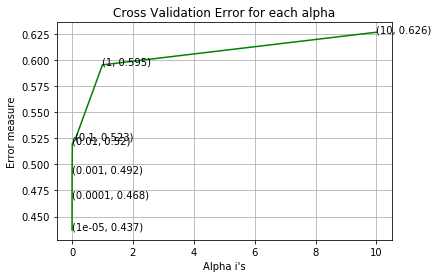

For values of best alpha =  1e-05 The train log loss is: 0.41423307125355213
For values of best alpha =  1e-05 The test log loss is: 0.4371728985939949
Total number of data points : 16500


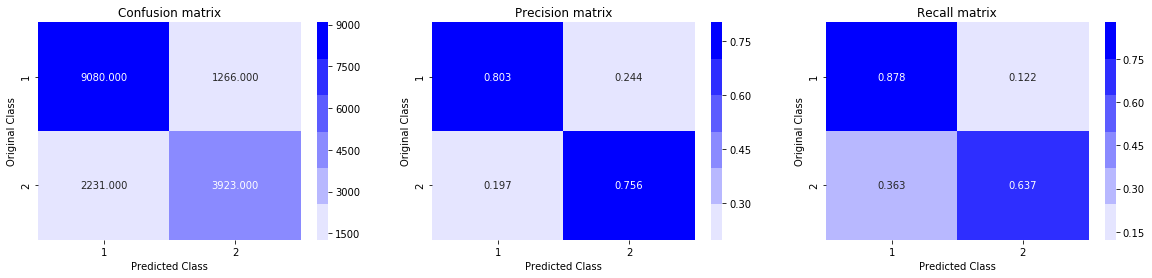

In [69]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    predict_y = sig_clf.predict_proba(X_te)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.3 XGBoost </h2>

In [79]:
#https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
from xgboost import XGBClassifier
params = {"max_depth":[1, 2, 3, 4], "n_estimators":[100, 250, 500, 700, 900, 1000]}

xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic',silent=True, nthread=1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='f1', n_jobs=2, cv=4, verbose=3, random_state=1001 )
random_search.fit(X_tr_old, y_train) 

estimators = random_search.best_params_["n_estimators"]
depth = random_search.best_params_["max_depth"]
print("Best max_depth:",depth)
print("Best n_estimators:",estimators)
    

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 827.0min finished


Best max_depth: 4
Best n_estimators: 1000


In [145]:
xgb=XGBClassifier(n_estimators=estimators, learning_rate=0.02, colsample_bytree=1, max_depth=depth)
xgb.fit(X_tr_old,y_train)
clf=CalibratedClassifierCV(xgb,method='sigmoid')
clf.fit(X_tr_old,y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    learning_rate=0.02,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=1000, n_jobs=1,
                                                    nthread=None,
                                                    objective='binary:logistic',
                                                    random_stat

train loss 0.295134035659196
test loss 0.35743469416166646
Total number of data points : 16500


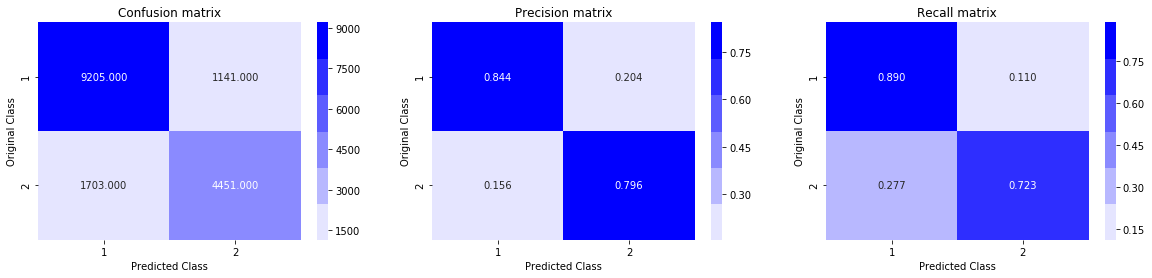

In [162]:
predict_y = clf.predict_proba(X_tr_old)
print ('train loss',log_loss(y_train, predict_y))

predict_y = clf.predict_proba(X_te_old)
print ('test loss',log_loss(y_test, predict_y,labels=clf.classes_, eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y[:,1])
